# Capstone Project - Berlin Apartments and Venues
### Applied Data Science Capstone by IBM on Coursera

## Table of contents
* [Import libraries](#import)
* [Web Scraping](#scrape)
* [Exploratory Data Analysis](#eda)
* [Foursquare API](#foursquare)
* [Venues Analysis](#venues)
* [K-Means Modeling](#kmeans)
* [Maps and Clustering Analysis](#maps)

## Import libraries & Configure Notebook<a name="import"></a>

In [1]:
import warnings
import pandas as pd
import numpy as np
import requests
import geopandas
import geopy
import folium
import time
import random
import re
import matplotlib. pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from requests import get
from bs4 import BeautifulSoup
from folium import IFrame
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist

In [2]:
# Some configurations for the notebook

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
geopy.geocoders.options.default_timeout = 7

## Web Scraping<a name="scrape"></a>

In [3]:
def immobilien_scraper(n, r1, r2):

    urls = []
    neighborhoods = []
    prices = []
    sqms = []
    rooms = []
    addresses = []
    page_number = 0

    for page in range(1, n):
        # Loop through the selected pages
        page_number += 1
        url ='https://www.immobilienscout24.de/Suche/de/berlin/berlin/wohnung-mieten?numberofrooms='+str(r1)+'-'+str(r2)+'&pagenumber='+str(page)
        r = get(url)
        page_html = BeautifulSoup(r.text, 'html.parser')

        # Get the div where the details of the appartment are presented
        house_containers = page_html.find_all('div', class_="result-list-entry__data")
        if house_containers != []:
            for container in house_containers:

                # Listing ID
                id_number = container.find('button').get('data-id')
                if id_number == None:
                    continue
                urls.append('https://www.immobilienscout24.de/expose/' + id_number)

                # Location
                location = container.find_all('div')[1].text
                location = location.split(',')   
                if len(location)>2:
                    address = location[0]
                    neighborhood = location[1]
                elif len(location)==2:
                    address = None
                    neighborhood = location[0]
                else:
                    continue
                neighborhood = neighborhood.replace(' ', '')
                neighborhoods.append(neighborhood)
                addresses.append(address)

                # Price            
                price = container.find_all('div')[5].find_all('dd')[0].text
                price = price.replace(' €', '')
                price = price.replace('.', '')
                price = price.replace(',', '.')
                prices.append(float(price))

                # Square Meters
                sqm = container.find_all('div')[5].find_all('dd')[1].text
                sqm = sqm.replace(' m²', '')
                sqm = sqm.replace(',', '.')
                sqms.append(float(sqm))

                # Number of Rooms
                room = container.find_all('div')[5].find_all('dd')[2].text
                room = room.split(' ')[0]
                rooms.append(room)

        # If no details of apartments are given proceed to the next page
        else:
            break

    print(f'You scraped {page_number} pages containing {len(neighborhoods)} properties.')
    
    return addresses, neighborhoods, prices, sqms, rooms, urls

In [4]:
results = immobilien_scraper(10, 2, 2)

berlin_flats = pd.DataFrame({
    'Address': results[0],
    'Neighborhood': results[1],
    'Price': results[2],
    'Sqm': results[3],
    'Rooms': results[4],
    'Url' : results[5]
})

You scraped 9 pages containing 170 properties.


## Exploratory Dana Analaysis<a name="eda"></a>

In [5]:
berlin_flats['Neighborhood'] = berlin_flats['Neighborhood'].str.extract(r"\(([A-Za-z]+)\)", expand=False)
berlin_flats['Neighborhood'] = berlin_flats['Neighborhood'].replace({'PrenzlauerBerg': 'Prenzlauer Berg'})
berlin_flats = berlin_flats.dropna().reset_index(drop=True)

In [6]:
# Functions to get the coordinates from the apartments

def get_lat(x):
    try:
        lat = locator.geocode(f'{x}, Berlin, Germany').latitude
    except AttributeError:
        lat = ' '
    return lat

def get_long(x):
    try:
        long = locator.geocode(f'{x}, Berlin, Germany').longitude
    except AttributeError:
        long = None
    return long

In [7]:
# Configure the geopy agent and apply the functions to the addresses

locator = Nominatim(user_agent='myGeocoder')

berlin_flats['Latitude'] = berlin_flats.Address.apply(get_lat)
berlin_flats['Longitude'] = berlin_flats.Address.apply(get_long)

In [8]:
berlin_flats = berlin_flats.dropna().reset_index(drop=True)
berlin_flats.head()

Address Neighborhood    Price    Sqm Rooms  \
0  Löwenberger Straße  7  Lichtenberg  1014.30  57.96     2   
1  Rosenfelder Ring  160  Lichtenberg   905.38  62.44     2   
2        Nahariyastr. 33    Tempelhof   490.64  60.00     2   
3           Nesselweg 17       Pankow   830.00  65.30     2   
4             Voßstr. 25        Mitte  1170.59  61.61     2   

                                                 Url Latitude  Longitude  
0  https://www.immobilienscout24.de/expose/114811751  52.5109  13.507728  
1  https://www.immobilienscout24.de/expose/116981879   52.512  13.510029  
2  https://www.immobilienscout24.de/expose/117754343  52.3928  13.418217  
3  https://www.immobilienscout24.de/expose/117395377  52.5981  13.380998  
4  https://www.immobilienscout24.de/expose/108376992  52.5109  13.379652

In [9]:
berlin_flats['PricePerSqm'] = berlin_flats['Price'] / berlin_flats['Sqm']
berlin_flats.head()

Address Neighborhood    Price    Sqm Rooms  \
0  Löwenberger Straße  7  Lichtenberg  1014.30  57.96     2   
1  Rosenfelder Ring  160  Lichtenberg   905.38  62.44     2   
2        Nahariyastr. 33    Tempelhof   490.64  60.00     2   
3           Nesselweg 17       Pankow   830.00  65.30     2   
4             Voßstr. 25        Mitte  1170.59  61.61     2   

                                                 Url Latitude  Longitude  \
0  https://www.immobilienscout24.de/expose/114811751  52.5109  13.507728   
1  https://www.immobilienscout24.de/expose/116981879   52.512  13.510029   
2  https://www.immobilienscout24.de/expose/117754343  52.3928  13.418217   
3  https://www.immobilienscout24.de/expose/117395377  52.5981  13.380998   
4  https://www.immobilienscout24.de/expose/108376992  52.5109  13.379652   

   PricePerSqm  
0    17.500000  
1    14.500000  
2     8.177333  
3    12.710567  
4    19.000000

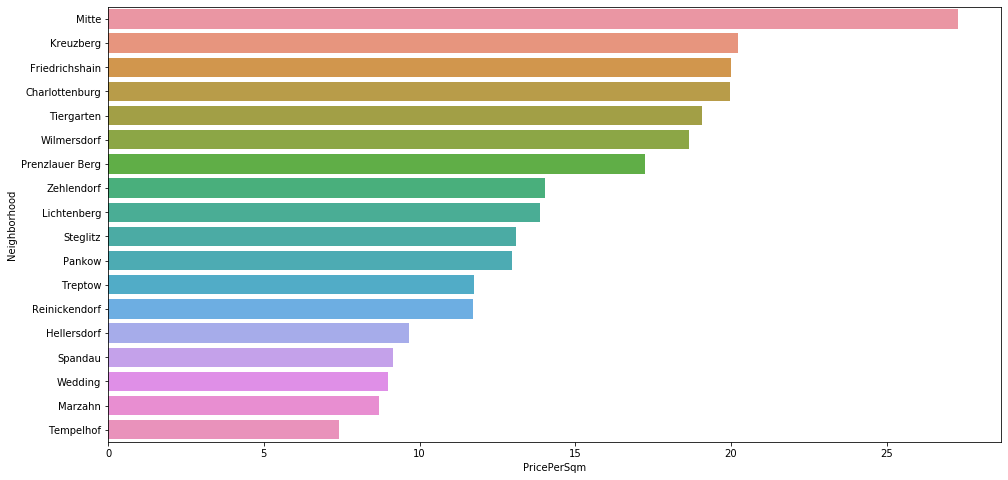

In [10]:
# Mean rental prices for each neighborhood per square meter

mean_per_neighborhood = berlin_flats.groupby('Neighborhood').mean().sort_values(by='PricePerSqm',
                                                                                ascending=False)

fig = plt.figure(figsize=(16, 8))
sns.barplot(mean_per_neighborhood['PricePerSqm'], mean_per_neighborhood.index);

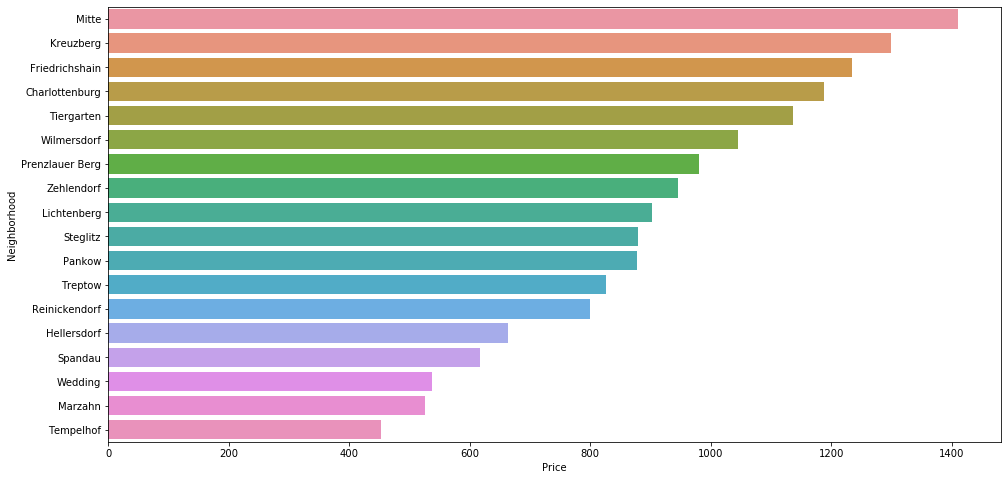

In [11]:
# Mean rental prices for each neighborhood

fig = plt.figure(figsize=(16, 8))
sns.barplot(mean_per_neighborhood['Price'].sort_values(ascending=False), mean_per_neighborhood.index);

## Foursquare Api<a name="foursquare"></a>

In [12]:
# Configure foursquare credentials

CLIENT_ID = 'your-cliend-id'
CLIENT_SECRET = 'your-client-secret'
VERSION = 'your-version'
LIMIT = 100

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat, 
            lng,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Address', 
                             'Address Latitude', 
                             'Address Longitude',
                             'Venue',
                             'Venue Latitude', 
                             'Venue Longitude',
                             'Venue Category']
    
    return(nearby_venues)

In [14]:
berlin_venues = getNearbyVenues(names=berlin_flats['Address'],
                                latitudes=berlin_flats['Latitude'],
                                longitudes=berlin_flats['Longitude'])

berlin_venues.head()

Address  Address Latitude  Address Longitude  \
0  Löwenberger Straße  7         52.510942          13.507728   
1  Löwenberger Straße  7         52.510942          13.507728   
2  Löwenberger Straße  7         52.510942          13.507728   
3  Löwenberger Straße  7         52.510942          13.507728   
4  Löwenberger Straße  7         52.510942          13.507728   

                   Venue  Venue Latitude  Venue Longitude Venue Category  
0      dm-drogerie markt       52.507772        13.512774      Drugstore  
1      Ormado Kaffeehaus       52.510300        13.501088    Coffee Shop  
2                   Lidl       52.509482        13.506732    Supermarket  
3  H Robert-Uhrig-Straße       52.510506        13.507779       Bus Stop  
4           Zamenhofpark       52.509516        13.503697           Park

## Venues Analysis<a name="venues"></a>

In [15]:
# Lets see the different kind of venues near each apartment

berlin_unique = len(berlin_venues['Venue Category'].unique())
print(f'There are {berlin_unique} unique venue categories in our scrape results.')

There are 273 unique venue categories in our scrape results.


In [16]:
# Let's see the most common venue categories

berlin_venues['Venue Category'].value_counts().head(20)

Hotel                    174
Café                     142
Supermarket              118
Bakery                    96
Italian Restaurant        89
Coffee Shop               81
Ice Cream Shop            58
German Restaurant         58
Plaza                     53
Park                      52
Bus Stop                  51
Gym / Fitness Center      45
Bar                       41
Restaurant                41
Clothing Store            40
Drugstore                 39
Vietnamese Restaurant     38
Asian Restaurant          32
Organic Grocery           32
Pub                       31
Name: Venue Category, dtype: int64

In [17]:
# one hot encoding so that we represent our categorical variables as binary vectors
berlin_onehot = pd.get_dummies(berlin_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
berlin_onehot['Address'] = berlin_venues['Address'] 

# move neighborhood column to the first column
fixed_columns = [berlin_onehot.columns[-1]] + list(berlin_onehot.columns[:-1])
berlin_onehot = berlin_onehot[fixed_columns]

berlin_grouped = berlin_onehot.groupby('Address').mean().reset_index()
berlin_grouped.head()

Address  ATM  Adult Boutique  African Restaurant  \
0         Bachstraße 4  0.0             0.0                 0.0   
1   Bornholmer Str. 68  0.0             0.0                 0.0   
2       Boyenstraße 33  0.0             0.0                 0.0   
3       Boyenstraße 36  0.0             0.0                 0.0   
4  Charlottenstraße 75  0.0             0.0                 0.0   

   American Restaurant  Antique Shop  Argentinian Restaurant  Art Gallery  \
0                  0.0           0.0                     0.0     0.000000   
1                  0.0           0.0                     0.0     0.000000   
2                  0.0           0.0                     0.0     0.000000   
3                  0.0           0.0                     0.0     0.000000   
4                  0.0           0.0                     0.0     0.037037   

   Art Museum  Asian Restaurant  Athletics & Sports  Auto Dealership  \
0         0.0          0.000000            0.040000              0.0   
1         0.0          0.000000            0.000000              0.0   
2         0.0          0.000000            0.040000              0.0   
3         0.0          0.000000            0.037037              0.0   
4         0.0          0.018519            0.000000              0.0   

   Auto Garage  Automotive Shop  BBQ Joint  Bagel Shop    Bakery  Bank  \
0          0.0              0.0        0.0         0.0  0.040000   0.0   
1          0.0              0.0        0.0         0.0  0.125000   0.0   
2          0.0              0.0        0.0         0.0  0.120000   0.0   
3          0.0              0.0        0.0         0.0  0.148148   0.0   
4          0.0              0.0        0.0         0.0  0.018519   0.0   

        Bar  Bath House  Bavarian Restaurant  Beach Bar  Bed & Breakfast  \
0  0.000000         0.0             0.000000        0.0              0.0   
1  0.041667         0.0             0.000000        0.0              0.0   
2  0.000000         0.0             0.000000        0.0              0.0   
3  0.000000         0.0             0.000000        0.0              0.0   
4  0.018519         0.0             0.018519        0.0              0.0   

   Beer Bar  Beer Garden  Beer Store  Big Box Store  Bike Rental / Bike Share  \
0       0.0          0.0         0.0            0.0                       0.0   
1       0.0          0.0         0.0            0.0                       0.0   
2       0.0          0.0         0.0            0.0                       0.0   
3       0.0          0.0         0.0            0.0                       0.0   
4       0.0          0.0         0.0            0.0                       0.0   

   Bike Shop  Bistro  Boarding House  Bookstore  Border Crossing  Boutique  \
0        0.0    0.04             0.0        0.0         0.000000       0.0   
1        0.0    0.00             0.0        0.0         0.041667       0.0   
2        0.0    0.00             0.0        0.0         0.000000       0.0   
3        0.0    0.00             0.0        0.0         0.000000       0.0   
4        0.0    0.00             0.0        0.0         0.000000       0.0   

   Bowling Alley  Brasserie  Breakfast Spot  Brewery  Building  Burger Joint  \
0            0.0        0.0        0.000000      0.0       0.0           0.0   
1            0.0        0.0        0.000000      0.0       0.0           0.0   
2            0.0        0.0        0.000000      0.0       0.0           0.0   
3            0.0        0.0        0.000000      0.0       0.0           0.0   
4            0.0        0.0        0.018519      0.0       0.0           0.0   

   Burrito Place  Bus Stop  Butcher      Café  Camera Store  Canal Lock  \
0       0.000000  0.040000      0.0  0.120000           0.0         0.0   
1       0.000000  0.000000      0.0  0.000000           0.0         0.0   
2       0.000000  0.040000      0.0  0.080000           0.0         0.0   
3       0.000000  0.037037      0.0  0.074074           0.0         0.0   
4 

## K-Means Modeling<a name="kmeans"></a>

In [18]:
df = berlin_grouped.drop('Address', 1)

In [19]:
distortions = []
K = range(1,50)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df)
    distortions.append(kmeanModel.inertia_)

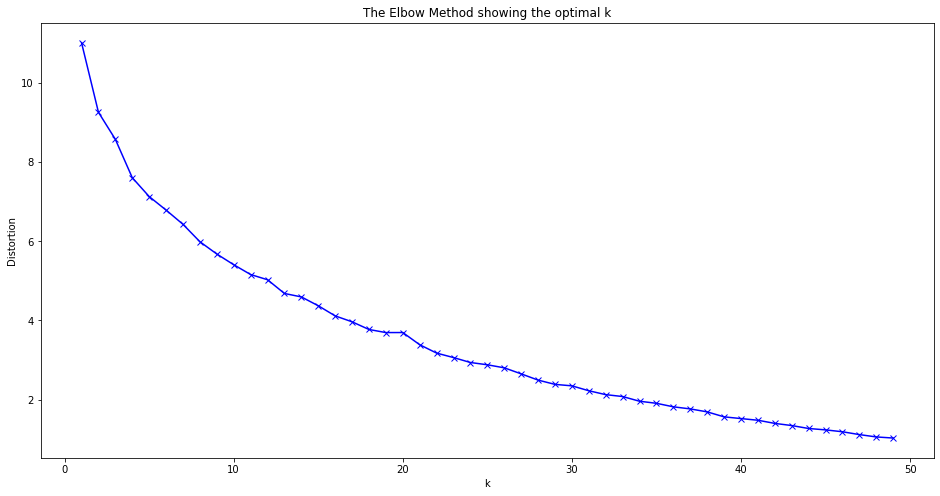

In [20]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [22]:
num_top_venues = 20

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Address']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Address'] = berlin_grouped['Address']

for ind in np.arange(berlin_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(berlin_grouped.iloc[ind, :], 
                                                                          num_top_venues)

neighborhoods_venues_sorted.head()

Address 1st Most Common Venue 2nd Most Common Venue  \
0         Bachstraße 4                  Café           Supermarket   
1   Bornholmer Str. 68                Bakery                Garden   
2       Boyenstraße 33                Bakery                  Café   
3       Boyenstraße 36                Bakery    Italian Restaurant   
4  Charlottenstraße 75                 Hotel           Coffee Shop   

  3rd Most Common Venue       4th Most Common Venue 5th Most Common Venue  \
0                 Hotel         Sporting Goods Shop            Restaurant   
1          Tram Station           Convenience Store                 Trail   
2                  Park                       Trail    Italian Restaurant   
3                  Café                        Park                 Trail   
4        Science Museum  Modern European Restaurant           Art Gallery   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0           Flea Market                Bistro             Gastropub   
1                 Plaza           Coffee Shop                  Park   
2         Historic Site                  Food     Outdoor Sculpture   
3         Historic Site                  Food     Outdoor Sculpture   
4           Salad Place     German Restaurant         Burrito Place   

  9th Most Common Venue    10th Most Common Venue 11th Most Common Venue  \
0      Pedestrian Plaza                 Roof Deck   Gym / Fitness Center   
1  Pakistani Restaurant                Smoke Shop        Border Crossing   
2          Skating Rink  Mediterranean Restaurant               Bus Stop   
3          Skating Rink  Mediterranean Restaurant               Bus Stop   
4  Gym / Fitness Center            Chocolate Shop           Concert Hall   

  12th Most Common Venue    13th Most Common Venue 14th Most Common Venue  \
0                Theater           Harbor / Marina                 Bakery   
1            Supermarket             Grocery Store                 Lounge   
2   Gym / Fitness Center               Coffee Shop                  River   
3   Gym / Fitness Center               Coffee Shop                  River   
4                 Hostel  Mediterranean Restaurant           Noodle House   

  15th Most Common Venue 16th Most Common Venue 17th Most Common Venue  \
0               Bus Stop              Hotel Bar                    Pub   
1                    Bar     Light Rail Station    Sporting Goods Shop   
2                RV Park             Restaurant     Athletics & Sports   
3                RV Park             Restaurant     Athletics & Sports   
4        Organic Grocery           Perfume Shop                  Plaza   

  18th Most Common Venue 19th Most Common Venue 20th Most Common Venue  
0     Turkish Restaurant     Athletics & Sports             Waterfront  
1          Historic Site         Ice Cream Shop  Vietnamese Restaurant  
2           Cupcake Shop                 Hostel                  Hotel  
3           Cupcake Shop                 Hostel                  Hotel  
4    Rental Car Location         History Museum            Yoga Studio

In [23]:
# set number of clusters
kclusters = 20

berlin_grouped_clustering = berlin_grouped.drop('Address', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(berlin_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Label', kmeans.labels_)

berlin_merged = berlin_flats

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
berlin_merged = berlin_merged.join(neighborhoods_venues_sorted.set_index('Address'), on='Address')

berlin_merged['Cluster Label'].unique()

array([ 0,  8,  6, 12,  3, 19, 10,  5, 11,  1, 16, 17, 14,  7, 15, 13,  9,
        2, 18,  4], dtype=int32)

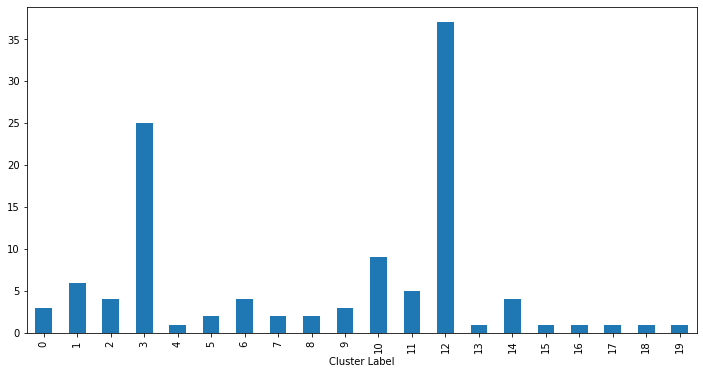

In [24]:
# Number of apartments per cluster

dist = berlin_merged.groupby('Cluster Label')['Address'].count()
plt.figure(figsize=(12,6))
dist.plot(kind='bar');

## Maps and Cluster Analysis<a name="maps"></a>

In [25]:
# create map
map_clusters = folium.Map([locator.geocode('Berlin, Germany').latitude, 
                           locator.geocode('Berlin, Germany').longitude], 
                           zoom_start=10)


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(berlin_merged['Latitude'], 
                                  berlin_merged['Longitude'], 
                                  berlin_merged['Address'], 
                                  berlin_merged['Cluster Label'].astype(int)):
    
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

In [26]:
berlin_map = folium.Map([locator.geocode('Berlin, Germany').latitude, 
                         locator.geocode('Berlin, Germany').longitude], 
                         zoom_start=15)

In [27]:
def analyze_cluster(n):


    berlin_cluster = berlin_merged.loc[berlin_merged['Cluster Label'] == n, 
                                       berlin_merged.columns[[0]+
                                                             [1]+
                                                             list(range(5, berlin_merged.shape[1]))]].reset_index(drop=True)
    
    return berlin_cluster

In [28]:
# Add apartment and details markers to the map
for lat, long, url, address, price, price_per_sqm, neighborhood, cluster in zip(berlin_merged['Latitude'], 
                                                                                berlin_merged['Longitude'],
                                                                                berlin_merged['Url'],
                                                                                berlin_merged['Address'],
                                                                                berlin_merged['Price'],
                                                                                berlin_merged['PricePerSqm'],
                                                                                berlin_merged['Neighborhood'],
                                                                                berlin_merged['Cluster Label']):

    html="""
        <h4><a href={url} target="_blank">Url</a></h4>
        <ul>
            <li>Address: {address}</li>
            <li>Price: {price}</li>
            <li>Price per Sqm: {price_per_sqm}</li>
            <li>Neighborhood: {neighborhood}</li>
            <li>Cluster: {cluster}
        </ul>
    """.format(url=url,
               address=address,
               price=price,
               price_per_sqm=price_per_sqm,
               neighborhood=neighborhood,
               cluster=cluster)
        
    iframe = folium.IFrame(html=html, width=300, height=180)
    popup = folium.Popup(iframe, max_width=2650)

    folium.Marker([lat, long], popup=popup).add_to(berlin_map)

In [29]:
# Add venue markers to the map
for lat, long, venue, category in zip(berlin_venues['Venue Latitude'], 
                                      berlin_venues['Venue Longitude'], 
                                      berlin_venues['Venue'], 
                                      berlin_venues['Venue Category']):

    label = category
    label = folium.Popup(label, parse_html=True, encoding='cp500')
    folium.CircleMarker(
        [lat, long],
        radius=10,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.5,
        parse_html=False).add_to(berlin_map)

In [30]:
berlin_map

In [31]:
def analyze_cluster(n):


    berlin_cluster = berlin_merged.loc[berlin_merged['Cluster Label'] == n, 
                                       berlin_merged.columns[[0]+
                                                             [1]+
                                                             list(range(5, berlin_merged.shape[1]))]].reset_index(drop=True)
    berlin_cluster = berlin_cluster.drop(columns=['Neighborhood', 'Latitude', 'Longitude'])
    return berlin_cluster

In [32]:
analyze_cluster(5)

Address                                                Url  \
0     Flämingstraße 70  https://www.immobilienscout24.de/expose/115916620   
1  Havelländer Ring 33  https://www.immobilienscout24.de/expose/116931340   

   PricePerSqm  Cluster Label 1st Most Common Venue 2nd Most Common Venue  \
0    10.100000              5           Supermarket          Tram Station   
1     7.922824              5           Supermarket          Tram Station   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0           Yoga Studio           Film Studio           Event Space   
1              Bus Stop           Yoga Studio           Flea Market   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0    Falafel Restaurant        Farmers Market  Fast Food Restaurant   
1    Falafel Restaurant        Farmers Market  Fast Food Restaurant   

  9th Most Common Venue 10th Most Common Venue 11th Most Common Venue  \
0   Filipino Restaurant            Flea Market    Empanada Restaurant   
1   Filipino Restaurant            Film Studio            Flower Shop   

  12th Most Common Venue 13th Most Common Venue 14th Most Common Venue  \
0            Flower Shop      Fondue Restaurant                   Food   
1   Ethiopian Restaurant      Fondue Restaurant                   Food   

  15th Most Common Venue 16th Most Common Venue 17th Most Common Venue  \
0      Food & Drink Shop             Food Truck      French Restaurant   
1      Food & Drink Shop             Food Truck      French Restaurant   

  18th Most Common Venue 19th Most Common Venue 20th Most Common Venue  
0   Ethiopian Restaurant      Electronics Store     Frozen Yogurt Shop  
1            Event Space    Empanada Restaurant     Frozen Yogurt Shop